# Product Matching Project -- BT's dataset - S-BERT model


### Key steps:
    1. Load benchmark STSB datasets
    2. Text Preprocessing
    3. Calculate Lexical overlap: Jaccard Similarity 
    4. Load LLM model: SBERT
    5. Semantic Embedding
    6. Cosine Similarity
    7. Combine Lexical and Semantic similairity 
    8. Product Matching based on Combined similarity

In [1]:
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity as sk_cosine_similarity
import numpy as np
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Load Dataset

In [2]:
df = pd.read_parquet('../../datasets/real_data/grocery/matches_training.parquet',)
df.head(3)

,base_title,base_size,base_brand,base_description,base_source_store,base_category,base_sku,comp_title,comp_size,comp_brand,...,string_sim_score,labels,current_model_score,new_model_score,desc_key,score,dup_key,base_uuid,comp_uuid,row_num
0,"Healthy Choice Power Bowls, Chicken & Quinoa 1...",nan,Healthy Choice,"Chicken, quinoa, and vegetables.",llmsynthetic_llmsynthetic,Food,a1d3406e59,"Weight Watchers Smart Ones, Chicken & Quinoa 1...",12 oz.,Weight Watchers,...,0.6046511627906976,0.0,0.7183989882469177,0.0,"healthy choice power bowls, chicken & quinoa 1...",nan,nan,nan,nan,nan
1,Minute Maid Limeade,nan,Minute Maid,"Homemade taste, no artificial flavors",llmsynthetic_llmsynthetic,Produce,1193b16878,"Sunkist Limes, 10 lb bag",nan,Sunkist,...,0.4,0.0,0.6332633793354034,0.0,"minute maid limeade, 1 gallonsunkist limes, 10...",nan,nan,nan,nan,nan
2,Cheesecake Squares-16 pieces,nan,Entenmann's,"Delicious cheesecake squares, individually wra...",llmsynthetic_llmsynthetic,Bakery,b279467c42,Cheesecake Ice Cream-1.5 qt.,nan,Edy's,...,0.5490196078431373,0.0,0.762024313211441,0.0,cheesecake squares-16 piecescheesecake ice cre...,nan,nan,nan,nan,nan


In [3]:
df = pd.read_parquet('../../datasets/real_data/grocery/matches_training.parquet',)
catalog_a, catalog_b, score = list(df['base_description']), list(df['comp_description']), list(df['string_sim_score'])

number_of_rows = 10
catalog_a = catalog_a[:number_of_rows]
catalog_b = catalog_b[:number_of_rows]
ref_score = score[:number_of_rows]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278495 entries, 0 to 278494
Data columns (total 58 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   base_title               278495 non-null  object
 1   base_size                278495 non-null  object
 2   base_brand               278495 non-null  object
 3   base_description         278495 non-null  object
 4   base_source_store        278495 non-null  object
 5   base_category            278495 non-null  object
 6   base_sku                 278495 non-null  object
 7   comp_title               278495 non-null  object
 8   comp_size                278495 non-null  object
 9   comp_brand               278495 non-null  object
 10  comp_description         278495 non-null  object
 11  comp_source_store        278495 non-null  object
 12  comp_sku                 278495 non-null  object
 13  base_uom                 198495 non-null  object
 14  base_upc            

In [5]:
# df = pd.read_csv('../../datasets/stsb/stsb_train',)
# catalog_a, catalog_b, score = list(df['sentence1']), list(df['sentence2']), list(df['score'])

# number_of_rows = 10
# catalog_a = catalog_a[:number_of_rows]
# catalog_b = catalog_b[:number_of_rows]
# ref_score = score[:number_of_rows]

## 2. Tokenization / Text Preprocessing


Before encoding or comparing texts, we normalize them to reduce noise.

Common techniques:

    - Lowercasing
    - Removing punctuation
    - Removing extra whitespace
    - Tokenization (splitting into words)

Why?
It improves consistency and reduces variability.
E.g., "256GB" vs "256 GB" — preprocessing helps align them better.

In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Make sure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ----------- Preprocessing ----------
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove excess spaces
    tokens = text.split()
    # tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/egharibnezhad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:

# ----------- Preprocess titles -----------
catalog_a_clean = [preprocess(title) for title in catalog_a]
catalog_b_clean = [preprocess(title) for title in catalog_b]

In [8]:
import random
sampled_pairs = random.sample(list(zip(catalog_a, catalog_a_clean)), k=3)
sampled_pairs

[('Mission Blue Corn 350 Tortilla Chips.',
  'mission blue corn 350 tortilla chips'),
 ('Tender and juicy pork chop, marinated with a savory blend of herbs and spices, and ready to be grilled or pan-fried for a delicious meal.',
  'tender and juicy pork chop marinated with a savory blend of herbs and spices and ready to be grilled or panfried for a delicious meal'),
 ('Made from mung beans, perfect for scramble.',
  'made from mung beans perfect for scramble')]

## 3. Jaccard Similarity Function



The `jaccard_similarity()` function calculates the **Jaccard Index**, a classic metric for measuring the similarity between two sets of tokens (words). Here's a breakdown of how it works:

**Formula**:

   $$
   \text{Jaccard}(A, B) = \frac{|A \cap B|}{|A \cup B|}
   $$

   * $A$ and $B$ are sets of tokens from each input string.
   * $|A \cap B|$ is the size of the intersection.
   * $|A \cup B|$ is the size of the union.

The score ranges from **0 to 1**:

* **0** → no common words
* **1** → identical token sets

---

### Why It's Useful

While **semantic similarity models** (like SBERT) capture meaning, Jaccard focuses purely on **surface-level lexical overlap** — the words themselves.

This is especially useful when:

* Product names contain shared keywords (e.g., model numbers, storage capacity, brand).
* You want a fast, interpretable similarity measure.
* Synonym handling isn't necessary.

For example:

* \`"iPhone 13 Pro Max 128GB


In [9]:
# ----------- Jaccard Similarity ----------
def jaccard_similarity(str1, str2):
    a, b = set(str1.split()), set(str2.split())
    intersection = a.intersection(b)
    union = a.union(b)
    return len(intersection) / len(union) if union else 0


# ----------- Jaccard Similarity (Token-level) -----------
jaccard_sim = np.zeros((len(catalog_a),len(catalog_b)))
for i, title_a in enumerate(catalog_a_clean):
    for j, title_b in enumerate(catalog_b_clean):
        jaccard_sim[i, j] = jaccard_similarity(title_a, title_b)



In [10]:
pd.DataFrame(jaccard_sim)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.000000,0.000000,0.000000,0.045455,0.142857,0.090909,0.083333,0.0,0.111111
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,0.000000,0.000000,0.076923,0.000000,0.083333,0.000000,0.000000,0.066667,0.0,0.000000
3,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.076923,0.000000,0.0,0.000000
4,0.040000,0.041667,0.035714,0.000000,0.322581,0.000000,0.071429,0.240000,0.0,0.037037
5,0.142857,0.000000,0.000000,0.000000,0.045455,0.600000,0.000000,0.000000,0.0,0.000000
6,0.090909,0.000000,0.000000,0.000000,0.038462,0.000000,0.454545,0.062500,0.0,0.076923
7,0.000000,0.000000,0.071429,0.000000,0.080000,0.000000,0.000000,0.214286,0.0,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.071429,0.066667,0.0,0.000000
9,0.100000,0.000000,0.000000,0.000000,0.083333,0.000000,0.071429,0.066667,0.0,0.300000


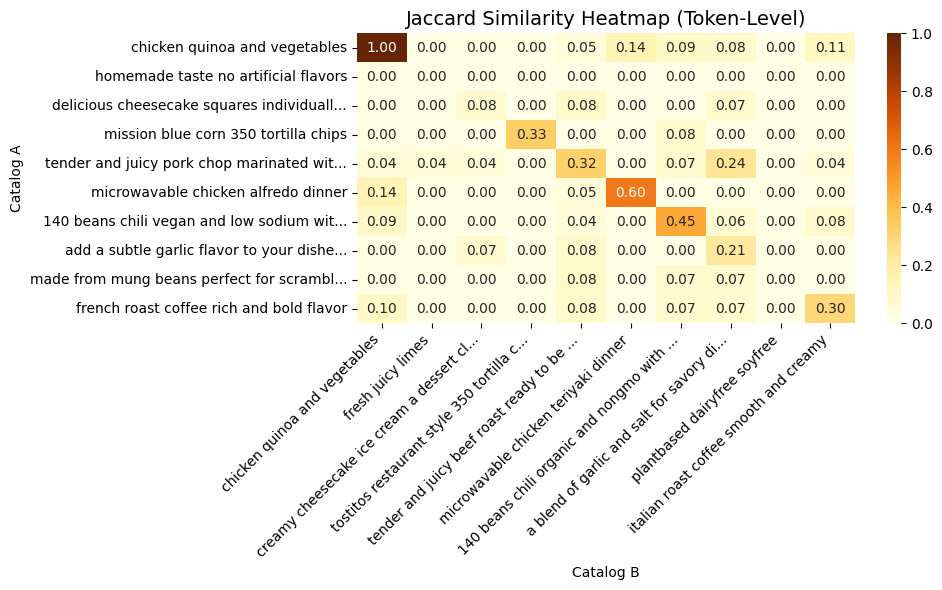

In [11]:
# Optional: truncate long strings for cleaner axis labels
def truncate(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + '...'

# Create shorter labels for readability
labels_a = [truncate(s) for s in catalog_a_clean]
labels_b = [truncate(s) for s in catalog_b_clean]

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(jaccard_sim, annot=True, fmt=".2f", cmap="YlOrBr",
            xticklabels=labels_b, yticklabels=labels_a)

plt.title("Jaccard Similarity Heatmap (Token-Level)", fontsize=14)
plt.xlabel("Catalog B")
plt.ylabel("Catalog A")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 4. Loading the SentenceTransformer Model


#### Loading the SentenceTransformer Model: `all-mpnet-base-v2`

### What This Line Does

```python
model = SentenceTransformer('all-mpnet-base-v2')
```

This line initializes a pre-trained **Sentence-BERT** model from the `sentence_transformers` library. The model `'all-mpnet-base-v2'` is a powerful transformer-based model used to generate **sentence embeddings** — fixed-size dense vectors that capture the semantic meaning of entire sentences or texts.

Link: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

This is a sentence-transformers model: It maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search.

---

### Why Use SentenceTransformer?

* **Sentence-BERT (SBERT)** improves upon traditional BERT by producing meaningful embeddings for entire sentences (instead of word-level embeddings).
* These embeddings allow efficient calculation of **semantic similarity** using measures like cosine similarity.
* SBERT enables various NLP tasks such as semantic search, clustering, paraphrase mining, and text matching without heavy custom training.

---

### Why `'all-mpnet-base-v2'`?

* **Architecture**: Based on MPNet — a transformer model that combines advantages from BERT and XLNet to better capture word dependencies.
* **High Accuracy**: Offers state-of-the-art performance on semantic textual similarity benchmarks, outperforming older models like `all-MiniLM-L6-v2`.
* **Balanced Efficiency**: Provides a good trade-off between embedding quality and computational cost.
* **General-Purpose**: Pretrained on large and diverse datasets, making it versatile across domains without fine-tuning.

---

### How It Works Internally

1. **Tokenization**
   The input sentence is split into subword tokens compatible with the MPNet vocabulary.

2. **Contextual Embedding Generation**
   MPNet generates contextual embeddings that capture both the local and global context of words.

3. **Pooling**
   A pooling layer (usually mean pooling) aggregates token embeddings into a single fixed-size vector representing the whole sentence.

4. **Output**
   The result is a dense numeric vector (typically 768 dimensions) encoding the semantic meaning of the input.

---

### Practical Considerations

* **Pretrained Benefits**
  Using this pretrained model saves time and compute resources compared to training your own embeddings.

* **Performance**
  Embeddings from `'all-mpnet-base-v2'` provide very accurate semantic similarity scores suitable for many real-world applications.

* **Hardware**
  While faster on GPUs, the model can run on CPUs for small-scale tasks.

* **Fine-tuning**
  The model can be fine-tuned on domain-specific data to further improve performance if needed.


In [12]:
model = SentenceTransformer('all-mpnet-base-v2') #110M
# model = SentenceTransformer('all-distilroberta-v1') #82M
# model = SentenceTransformer('roberta-base') #110M
# model = SentenceTransformer('sentence-transformers/all-roberta-large-v1') #355million


/home/egharibnezhad/apps/anaconda3/envs/pm-llms/lib/python3.9/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [13]:
print(model[0].auto_model.config)

MPNetConfig {
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "torch_dtype": "float32",
  "transformers_version": "4.52.4",
  "vocab_size": 30527
}



In [14]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")


Total parameters: 109,486,464


## 5. Semantic Embeddings

This step **converts each string from text into a dense numeric vector** called an *embedding*. The embeddings capture the semantic meaning of the sentences, allowing us to compare products beyond exact word matches.

* `catalog_a_clean` and `catalog_b_clean` are lists of preprocessed product titles (lowercased, punctuation removed).
* `model.encode()` passes each title through the Sentence-BERT (`SBERT`) model, which outputs a fixed-length vector representing the semantic content.
* `convert_to_tensor=True` ensures embeddings are returned as PyTorch tensors for fast GPU-enabled operations.

---

### Why Semantic Embeddings?

Traditional text similarity metrics (like Jaccard or simple token overlap) only measure surface-level lexical similarity. In contrast, **semantic embeddings** encode the *meaning* of sentences in a high-dimensional vector space.

* Embeddings allow us to recognize paraphrases, synonyms, and related concepts.
* For example:

  * `"Apple iPhone 13 Pro Max 128GB"`
  * `"iPhone 13 Pro Max 128 GB in Silver color"`
    Though worded differently, these have similar embeddings because they describe the same product.

---

### How Does SBERT Generate Embeddings?

SBERT builds on top of BERT and adapts it to produce meaningful sentence vectors:

1. **Tokenization**
   Input text is split into subword tokens using WordPiece or similar methods.

2. **Contextual Encoding**
   Tokens are passed through transformer layers to produce **contextual embeddings** — vectors for each token enriched by surrounding context.

3. **Pooling Layer**
   To get a *single* vector per sentence, SBERT applies a pooling operation over token embeddings. The most common is **mean pooling**: averaging token embeddings along the sequence length dimension.

4. **Final Embedding Vector**
   The result is a fixed-size vector (typically 768 dimensions for base models) representing the entire sentence’s semantic information.

---

### Mathematical Representation

* Let a sentence $S$ be tokenized into $T = [t_1, t_2, ..., t_n]$.
* SBERT produces contextual token embeddings:

$$
E = [\mathbf{e}_1, \mathbf{e}_2, ..., \mathbf{e}_n], \quad \mathbf{e}_i \in \mathbb{R}^d
$$

where $d$ is the embedding dimension (e.g., 768).

* The pooled sentence embedding $\mathbf{s}$ is computed as:

$$
\mathbf{s} = \frac{1}{n} \sum_{i=1}^n \mathbf{e}_i
$$

This vector $\mathbf{s} \in \mathbb{R}^d$ captures the semantic meaning of the sentence.

---

### Properties of SBERT Embeddings

* **Semantic Similarity**: Sentences with similar meaning produce embeddings close in the vector space.
* **Vector Space Geometry**: You can measure similarity via cosine similarity:

$$
\text{cosine\_sim}(\mathbf{s}_1, \mathbf{s}_2) = \frac{\mathbf{s}_1 \cdot \mathbf{s}_2}{\|\mathbf{s}_1\| \|\mathbf{s}_2\|}
$$

which ranges from -1 (opposite) to 1 (identical).

* **Transfer Learning**: SBERT is pretrained on large datasets with human-labeled semantic similarity scores, enabling it to generalize well to new text.

---

### Why Use `convert_to_tensor=True`?

* Returns embeddings as PyTorch tensors instead of numpy arrays.
* Enables GPU acceleration for downstream similarity calculations.
* Allows easy integration with PyTorch-based pipelines.

---

### Example Intuition

Suppose we have:

* $S_1 =$ `"Apple iPhone 13 Pro Max 128GB Silver"`
* $S_2 =$ `"iPhone 13 Pro Max 128 GB in Silver color"`

Even if the strings differ lexically, SBERT embeddings $\mathbf{s}_1$ and $\mathbf{s}_2$ will be very close in vector space, leading to a high cosine similarity score.

In [15]:
# ----------- Encode with SBERT -----------
embeddings_a = model.encode(catalog_a_clean, convert_to_tensor=True)
embeddings_b = model.encode(catalog_b_clean, convert_to_tensor=True)


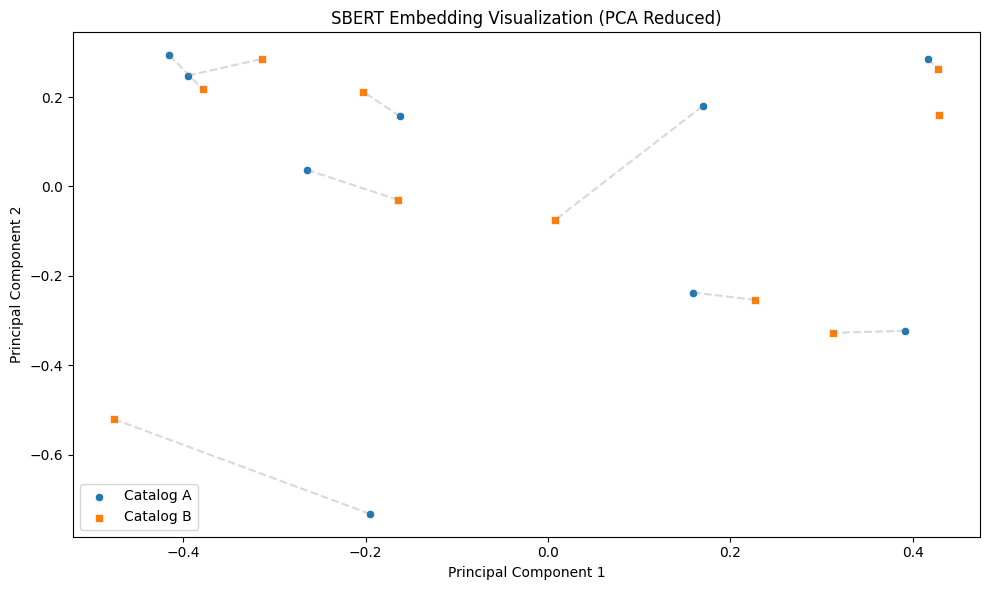

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Convert tensors to numpy
emb_a_np = embeddings_a.cpu().numpy()
emb_b_np = embeddings_b.cpu().numpy()

# Combine both sets of embeddings
all_embeddings = np.vstack((emb_a_np, emb_b_np))

# Reduce to 2D with PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split back into two sets
reduced_a = reduced_embeddings[:len(catalog_a_clean)]
reduced_b = reduced_embeddings[len(catalog_a_clean):]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_a[:, 0], y=reduced_a[:, 1], label="Catalog A", marker='o')
sns.scatterplot(x=reduced_b[:, 0], y=reduced_b[:, 1], label="Catalog B", marker='s')

# Optional: draw lines between closest pairs
for i in range(len(catalog_a_clean)):
    plt.plot([reduced_a[i, 0], reduced_b[i, 0]], 
             [reduced_a[i, 1], reduced_b[i, 1]], 
             color='gray', alpha=0.3, linestyle='--')

plt.title("SBERT Embedding Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.tight_layout()
plt.show()


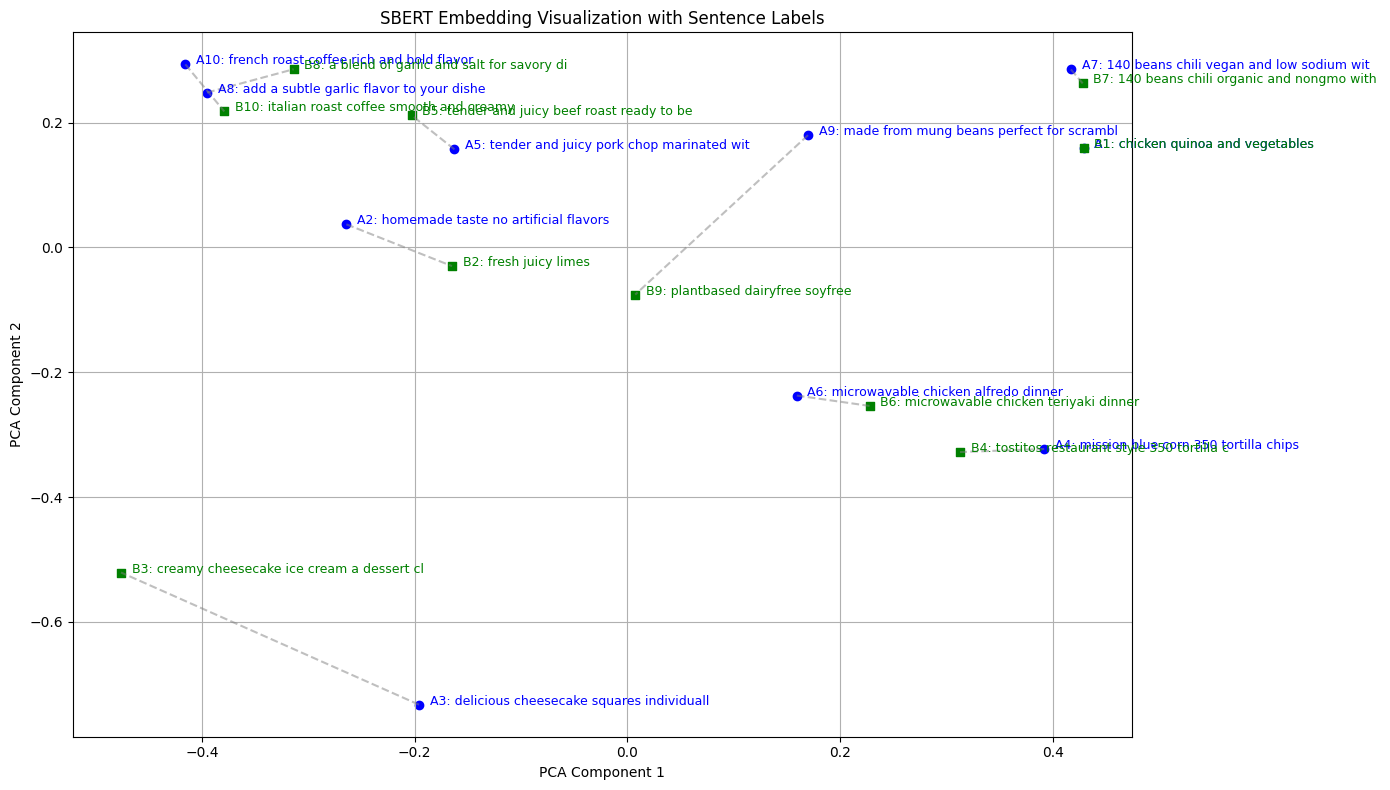

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

# Assume you already have these:
# catalog_a_clean and catalog_b_clean (your preprocessed sentence lists)
# embeddings_a and embeddings_b (SBERT output)

# Convert to NumPy
emb_a_np = embeddings_a.cpu().numpy()
emb_b_np = embeddings_b.cpu().numpy()

# Combine for joint PCA
all_embeddings = np.vstack((emb_a_np, emb_b_np))

# Reduce to 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(all_embeddings)

# Split back
reduced_a = reduced[:len(catalog_a_clean)]
reduced_b = reduced[len(catalog_a_clean):]

# Plot
plt.figure(figsize=(14, 8))

# Plot Catalog A points
for i, (x, y) in enumerate(reduced_a):
    plt.scatter(x, y, color='blue', marker='o')
    plt.text(x + 0.01, y, f"A{i+1}: {catalog_a_clean[i][:40]}", fontsize=9, color='blue')

# Plot Catalog B points
for i, (x, y) in enumerate(reduced_b):
    plt.scatter(x, y, color='green', marker='s')
    plt.text(x + 0.01, y, f"B{i+1}: {catalog_b_clean[i][:40]}", fontsize=9, color='green')

# Optional: draw dashed lines between A and B (assuming matching index)
for i in range(len(catalog_a_clean)):
    plt.plot(
        [reduced_a[i, 0], reduced_b[i, 0]],
        [reduced_a[i, 1], reduced_b[i, 1]],
        linestyle='--',
        color='gray',
        alpha=0.5
    )

plt.title("SBERT Embedding Visualization with Sentence Labels")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Cosine Similarity (Semantic)


```python
semantic_sim = util.cos_sim(embeddings_a, embeddings_b).cpu().numpy()
````

* **What it does:**
  This line calculates the **cosine similarity** between the sentence embeddings of two catalogs (`catalog_a` and `catalog_b`).

* **Why cosine similarity?**
  Cosine similarity measures the cosine of the angle between two vectors in a high-dimensional space:

  $$
  \text{cosine\_sim}(\mathbf{u}, \mathbf{v}) = \frac{\mathbf{u} \cdot \mathbf{v}}{\|\mathbf{u}\| \|\mathbf{v}\|}
  $$

  where:

  * $\mathbf{u}$ and $\mathbf{v}$ are embedding vectors for two sentences
  * $\cdot$ denotes the dot product
  * $\|\mathbf{u}\|$ and $\|\mathbf{v}\|$ are vector magnitudes (Euclidean norms)

* **Interpretation:**

  * Values range from -1 (completely opposite) to 1 (identical).
  * Higher scores mean higher semantic similarity, capturing meaning even when wording differs.

* **Details:**

  * `util.cos_sim` computes pairwise cosine similarities between all embeddings in `embeddings_a` and `embeddings_b`.
  * The result is a 2D matrix `semantic_sim` of shape `(len(catalog_a), len(catalog_b))`.
  * `.cpu().numpy()` transfers tensors to CPU and converts them to NumPy arrays for easy manipulation.



In [18]:

# ----------- Cosine Similarity (Semantic) -----------
semantic_sim = util.cos_sim(embeddings_a, embeddings_b).cpu().numpy()


In [19]:
pd.DataFrame(semantic_sim)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.236155,0.100729,0.302137,0.292737,0.381835,0.445769,0.267505,0.303051,0.165923
1,0.252216,0.324342,0.246271,0.242373,0.217681,0.150466,0.307701,0.419673,0.341137,0.276075
2,0.155334,0.191967,0.576434,0.352054,0.143898,0.258478,0.035337,0.080689,0.192276,0.075419
3,0.299623,0.276852,0.169922,0.768400,0.169335,0.306642,0.554812,0.105119,0.188305,0.145027
4,0.350140,0.306576,0.154302,0.288213,0.602449,0.309860,0.231352,0.385762,0.120403,0.287242
5,0.320309,0.044918,0.087026,0.294522,0.262425,0.777261,0.205860,0.229123,0.161046,0.248187
6,0.445846,0.213322,0.002848,0.420573,0.256561,0.213091,0.767126,0.257048,0.314963,0.260146
7,0.197601,0.243344,0.127317,0.153724,0.270789,0.204328,0.182449,0.728754,0.109572,0.229324
8,0.442260,0.263790,0.153558,0.356619,0.443226,0.318870,0.547499,0.289473,0.352111,0.372169
9,0.163487,0.224607,0.269774,0.167461,0.480801,0.123685,0.295201,0.238079,0.205162,0.712861


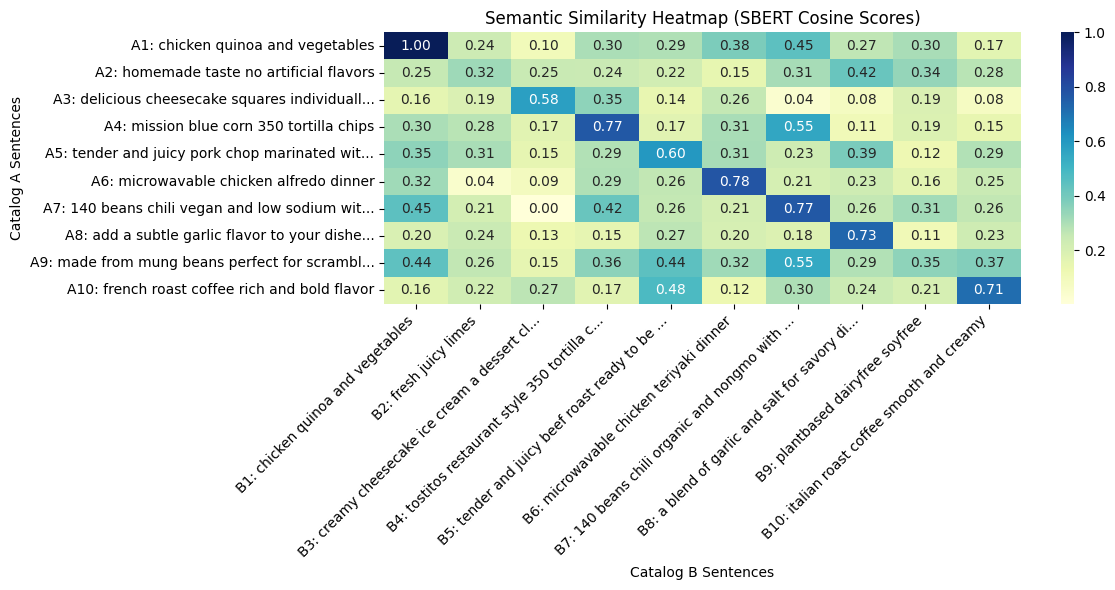

In [20]:
# Optionally truncate long strings for clarity
def truncate(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + '...'

labels_a = [f"A{i+1}: {truncate(s)}" for i, s in enumerate(catalog_a_clean)]
labels_b = [f"B{i+1}: {truncate(s)}" for i, s in enumerate(catalog_b_clean)]

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(semantic_sim, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=labels_b, yticklabels=labels_a)

plt.title("Semantic Similarity Heatmap (SBERT Cosine Scores)")
plt.xlabel("Catalog B Sentences")
plt.ylabel("Catalog A Sentences")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


---

## 7. Combining Scores



```python
combined_scores = 0.7 * semantic_sim + 0.3 * jaccard_sim
```

* **What it does:**
  This line combines the semantic and lexical similarity matrices into a single score matrix.

* **Why combine?**

  * **Semantic similarity** captures meaning but may miss exact keyword matches.
  * **Jaccard similarity** captures exact token overlap but not meaning.
  * Combining them leverages the strengths of both methods for better matching accuracy.

* **Weights:**

  * Semantic similarity is weighted **70%** (`0.7`) to prioritize meaning.
  * Jaccard similarity is weighted **30%** (`0.3`) to emphasize lexical overlap.

* **Result:**

  * `combined_scores` is a matrix where each entry represents the combined similarity score between product titles from both catalogs.

---


In [21]:
# ----------- Combine Scores -----------
combined_scores = 0.9 * semantic_sim + 0.1 * jaccard_sim


In [22]:
pd.DataFrame(combined_scores)

,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.212540,0.090656,0.271923,0.268008,0.357938,0.410283,0.249087,0.272746,0.160442
1,0.226994,0.291908,0.221644,0.218135,0.195913,0.135419,0.276931,0.377705,0.307023,0.248468
2,0.139800,0.172770,0.526483,0.316848,0.137842,0.232630,0.031804,0.079286,0.173049,0.067877
3,0.269660,0.249167,0.152930,0.724893,0.152401,0.275978,0.507023,0.094608,0.169474,0.130525
4,0.319126,0.280085,0.142443,0.259392,0.574462,0.278874,0.215360,0.371186,0.108363,0.262222
5,0.302564,0.040426,0.078323,0.265069,0.240728,0.759535,0.185274,0.206211,0.144941,0.223368
6,0.410353,0.191990,0.002563,0.378515,0.234751,0.191782,0.735868,0.237593,0.283467,0.241824
7,0.177841,0.219009,0.121728,0.138351,0.251710,0.183896,0.164204,0.677307,0.098615,0.206391
8,0.398034,0.237411,0.138202,0.320957,0.407237,0.286983,0.499892,0.267193,0.316900,0.334952
9,0.157138,0.202146,0.242797,0.150715,0.441054,0.111317,0.272824,0.220938,0.184646,0.671575


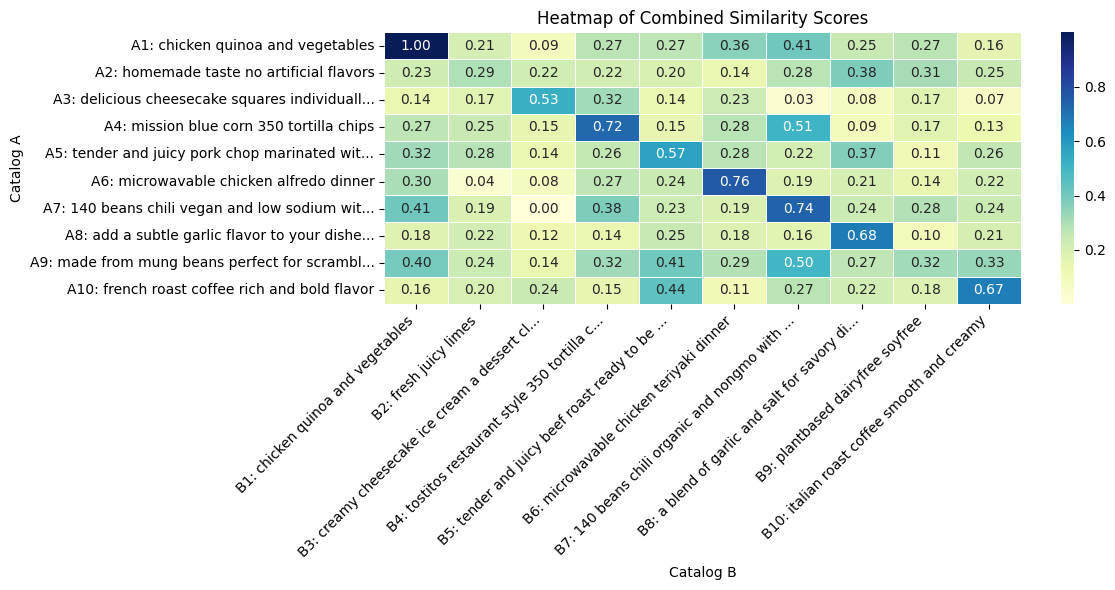

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Optional: truncate long sentences for readability
def truncate(text, max_len=40):
    return text if len(text) <= max_len else text[:max_len] + "..."

labels_a = [f"A{i+1}: {truncate(s)}" for i, s in enumerate(catalog_a_clean)]
labels_b = [f"B{i+1}: {truncate(s)}" for i, s in enumerate(catalog_b_clean)]

plt.figure(figsize=(12, 6))
sns.heatmap(combined_scores, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=labels_b, yticklabels=labels_a, linewidths=0.5)

plt.title("Heatmap of Combined Similarity Scores")
plt.xlabel("Catalog B")
plt.ylabel("Catalog A")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 8. Product Matching Based on Combined Similarity Scores


### What happens here?

* **Goal:** Identify the best matching products from `catalog_b` for each product in `catalog_a` based on the **combined similarity scores** (semantic + Jaccard).

* **Step-by-step explanation:**

  1. **Initialize parameters:**

     * `top_k = 2`: For each product in catalog A, we consider the top 2 best matches from catalog B.
     * `threshold = 0.5`: A minimum combined similarity score required to consider a match as valid.

  2. **Iterate over products in catalog A:**

     * For each product `i` in `catalog_a`, we print its original title.

  3. **Rank potential matches:**

     * Use `np.argsort(-combined_scores[i])` to sort the similarity scores in descending order (highest similarity first).
     * This gives the indices of catalog B products sorted by similarity to product `i`.

  4. **Select top matches above threshold:**

     * Loop through the top `k` matches.
     * For each match, check if the combined similarity score exceeds the threshold.
     * If yes, print the matched product title from catalog B and the similarity score.
     * Mark `found = True` to indicate at least one strong match was found.

  5. **If no strong match:**

     * If no product meets the threshold, print `"No strong match found."`

  6. **Formatting:**

     * Print a separator line (`"-" * 70`) for clarity between products.

---

### Why this approach?

* **Top-K matches:**
  Helps retrieve multiple possible matches for each product, useful if catalog B has near-duplicate entries.

* **Thresholding:**
  Filters out weak or irrelevant matches, reducing false positives.

* **Combined scores:**
  Using both semantic and lexical similarity makes matching more robust and precise.

---

### Practical considerations

* You can adjust `top_k` depending on how many matches you want to consider.
* The `threshold` can be tuned based on your dataset and the desired precision/recall trade-off.
* This output format is human-readable but can be adapted for automated downstream processing.

---

This matching step is the final and critical stage where similarity calculations translate into actionable product mappings!



In [24]:

# ----------- Match Products -----------
print("Product Matching Results:\n")
top_k = 2
threshold = 0.5

# Store matches for visualization
match_data = []

for i in range(len(catalog_a)):
    print(f"Catalog A: {catalog_a_clean[i]}")
    ranked_indices = np.argsort(-combined_scores[i])
    found = False
    for rank in range(top_k):
        idx = ranked_indices[rank]
        score = combined_scores[i][idx]
        if score >= threshold:
            print(f"  Match {rank+1}: {catalog_b_clean[idx]}")
            print(f"  Combined Score: {score:.4f}")
            print(f"reference score: {ref_score[i]}")
            match_data.append((catalog_a_clean[i], catalog_b[idx], score))
            found = True
    if not found:
        print("  No strong match found.")
    print("-" * 70)


Product Matching Results:

Catalog A: chicken quinoa and vegetables
  Match 1: chicken quinoa and vegetables
  Combined Score: 1.0000
reference score: 0.6046511627906976
----------------------------------------------------------------------
Catalog A: homemade taste no artificial flavors
  No strong match found.
----------------------------------------------------------------------
Catalog A: delicious cheesecake squares individually wrapped for convenience
  Match 1: creamy cheesecake ice cream a dessert classic
  Combined Score: 0.5265
reference score: 0.5490196078431373
----------------------------------------------------------------------
Catalog A: mission blue corn 350 tortilla chips
  Match 1: tostitos restaurant style 350 tortilla chips
  Combined Score: 0.7249
reference score: 0.6190476190476191
  Match 2: 140 beans chili organic and nongmo with corn
  Combined Score: 0.5070
reference score: 0.6190476190476191
-------------------------------------------------------------------

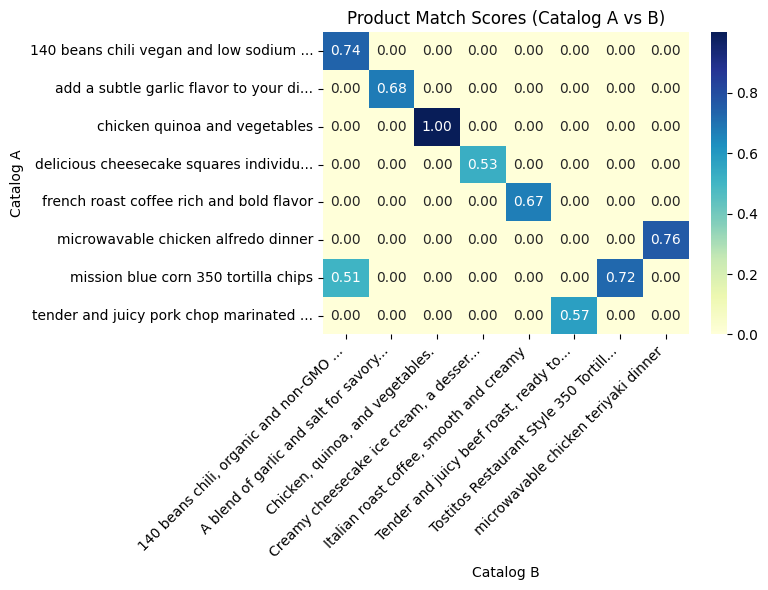

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------- Visualization -----------
if match_data:
    # Truncate helper function
    def truncate(text, max_len=40):
        return text if len(text) <= max_len else text[:max_len - 3] + "..."

    # Convert to heatmap matrix
    labels_a_full = sorted(set(x[0] for x in match_data))
    labels_b_full = sorted(set(x[1] for x in match_data))
    labels_a = [truncate(label) for label in labels_a_full]
    labels_b = [truncate(label) for label in labels_b_full]

    heatmap_matrix = np.zeros((len(labels_a), len(labels_b)))

    for a, b, score in match_data:
        i = labels_a_full.index(a)
        j = labels_b_full.index(b)
        heatmap_matrix[i, j] = score

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=labels_b, yticklabels=labels_a)
    plt.title("Product Match Scores (Catalog A vs B)")
    plt.xlabel("Catalog B")
    plt.ylabel("Catalog A")
    plt.xticks(rotation=45, ha="right")

    plt.tight_layout()
    plt.show()
else:
    print("No matches found to visualize.")
